# Modelação de time series - SARIMA

## Imports

In [2]:
import pandas as pd
import itertools
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
# ignore warnings
import warnings
warnings.filterwarnings('ignore')

## Leitura

In [3]:
braga_time_series = pd.read_csv('../model/datasets/FINALDATASET.csv')

# merge date and time columns into a datetime column
braga_time_series['datetime'] = pd.to_datetime(braga_time_series['date'] + ' ' + braga_time_series['time'])
braga_time_series.set_index('datetime', inplace=True)

# drop the time column
braga_time_series.drop('time', axis=1, inplace=True)
braga_time_series.head()

,longitude,latitude,no2,pm10,pm25,pm1,date,tempmax,tempmin,temp,...,precip,snow,windspeed,sealevelpressure,cloudcover,visibility,solarradiation,solarenergy,uvindex,AQI
datetime,,,,,,,,,,,,,,,,,,,,,
2020-01-01 00:00:00,-8.296389,41.449722,32.9,15.0,NaN,NaN,2020-01-01,55.4,50.2,52.8,...,0.32,0.0,16.9,1018.9,93.9,5.3,51.9,4.5,3.0,33.0
2020-01-01 01:00:00,-8.296389,41.449722,34.1,15.0,NaN,NaN,2020-01-01,55.4,50.2,52.8,...,0.32,0.0,16.9,1018.9,93.9,5.3,51.9,4.5,3.0,34.0
2020-01-01 02:00:00,-8.296389,41.449722,45.2,15.0,NaN,NaN,2020-01-01,55.4,50.2,52.8,...,0.32,0.0,16.9,1018.9,93.9,5.3,51.9,4.5,3.0,45.0
2020-01-01 03:00:00,-8.296389,41.449722,44.3,NaN,NaN,NaN,2020-01-01,55.4,50.2,52.8,...,0.32,0.0,16.9,1018.9,93.9,5.3,51.9,4.5,3.0,44.0
2020-01-01 04:00:00,-8.296389,41.449722,34.1,NaN,NaN,NaN,2020-01-01,55.4,50.2,52.8,...,0.32,0.0,16.9,1018.9,93.9,5.3,51.9,4.5,3.0,34.0


In [4]:
# replace missing values with the median
missing_columns = ['pm10', 'pm25', 'pm1', 'no2']

for column in missing_columns:
    braga_time_series[column] = braga_time_series[column].fillna(braga_time_series[column].median())

# remove NaT values from datetime index
braga_time_series = braga_time_series[braga_time_series.index.notnull()]

# drop the date column
braga_time_series.drop('date', axis=1, inplace=True)

braga_time_series.head()

,longitude,latitude,no2,pm10,pm25,pm1,tempmax,tempmin,temp,feelslike,...,precip,snow,windspeed,sealevelpressure,cloudcover,visibility,solarradiation,solarenergy,uvindex,AQI
datetime,,,,,,,,,,,,,,,,,,,,,
2020-01-01 00:00:00,-8.296389,41.449722,32.9,15.0,4.3,4.78,55.4,50.2,52.8,52.8,...,0.32,0.0,16.9,1018.9,93.9,5.3,51.9,4.5,3.0,33.0
2020-01-01 01:00:00,-8.296389,41.449722,34.1,15.0,4.3,4.78,55.4,50.2,52.8,52.8,...,0.32,0.0,16.9,1018.9,93.9,5.3,51.9,4.5,3.0,34.0
2020-01-01 02:00:00,-8.296389,41.449722,45.2,15.0,4.3,4.78,55.4,50.2,52.8,52.8,...,0.32,0.0,16.9,1018.9,93.9,5.3,51.9,4.5,3.0,45.0
2020-01-01 03:00:00,-8.296389,41.449722,44.3,15.0,4.3,4.78,55.4,50.2,52.8,52.8,...,0.32,0.0,16.9,1018.9,93.9,5.3,51.9,4.5,3.0,44.0
2020-01-01 04:00:00,-8.296389,41.449722,34.1,15.0,4.3,4.78,55.4,50.2,52.8,52.8,...,0.32,0.0,16.9,1018.9,93.9,5.3,51.9,4.5,3.0,34.0


## Modelação

In [5]:
train_size = int(len(braga_time_series) * 0.8)  # 80% for training
train_data = braga_time_series[:train_size]
test_data = braga_time_series[train_size:]

### SARIMA

### Determine the order of differencing (d), which helps make the time series stationary. Stationarity is an assumption of ARIMA models. You can use techniques like the Augmented Dickey-Fuller (ADF) test to check for stationarity. If the p-value is greater than a significance level (e.g., 0.05), it indicates that the series is not stationary and differencing is required. Repeat this step until the series becomes stationary.

In [6]:
result = adfuller(train_data['AQI'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])

ADF Statistic: -5.587053412322267
p-value: 1.3554618069600313e-06


Based on the results you provided, the ADF (Augmented Dickey-Fuller) test statistic is -5.798380586220405 and the corresponding p-value is 4.6934135928035885e-07, which is significantly smaller than the typical significance level of 0.05.

Since the p-value is below the significance level, it suggests that you can reject the null hypothesis of non-stationarity. In other words, the time series data (braga_time_series['AQI']) appears to be stationary. Therefore, there is no need for further differencing in this case.

With a stationary time series, you can proceed with determining the appropriate parameters (p and q) for the autoregressive (AR) and moving average (MA) components of the ARIMA model, respectively, and fit the model.

Please note that while the ADF test indicates stationarity in this case, it's still important to inspect other diagnostic plots and evaluate the model's performance to ensure its adequacy for forecasting or further analysis.

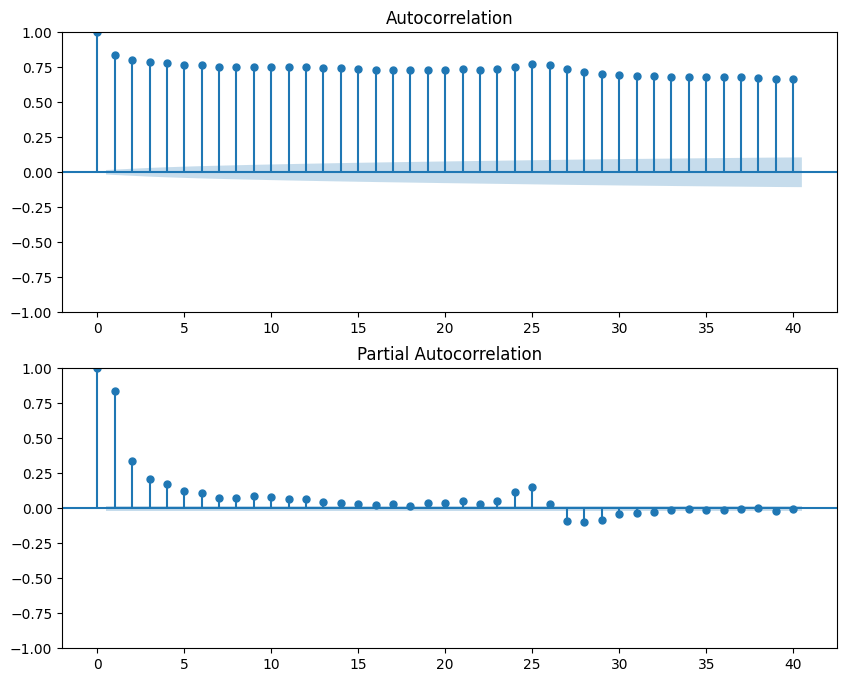

In [7]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))
plot_acf(train_data['AQI'], ax=ax1, lags=40)
plot_pacf(train_data['AQI'], ax=ax2, lags=40)
plt.show()

In [8]:
p = 0 # we can see that the PACF is 0 after lag 1
d = 0 # its already stationary
q = 25 # we can see that the ACF is 0 after lag 26
model = ARIMA(train_data['AQI'], order=(p, d, q))
model_fit = model.fit()

                               SARIMAX Results                                
Dep. Variable:                    AQI   No. Observations:                14664
Model:                ARIMA(0, 0, 25)   Log Likelihood              -78676.307
Date:                Tue, 13 Jun 2023   AIC                         157406.613
Time:                        20:38:35   BIC                         157611.628
Sample:                             0   HQIC                        157474.710
                              - 14664                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         83.5304      5.561     15.022      0.000      72.632      94.429
ma.L1          0.4409      0.005     84.222      0.000       0.431       0.451
ma.L2          0.3908      0.007     53.698      0.0

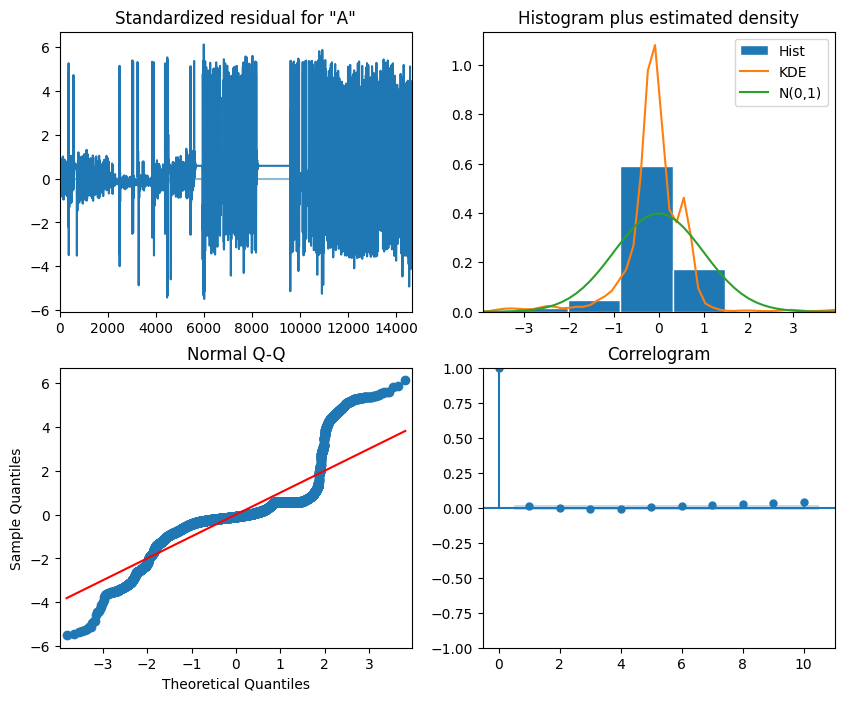

In [9]:
print(model_fit.summary())
model_fit.plot_diagnostics(figsize=(10, 8))
plt.show()

In [10]:
predictions = model_fit.predict(start=len(train_data), end=len(train_data) + len(test_data) - 1)

In [11]:
predictions

14664    44.764525
14665    48.104129
14666    50.303573
14667    52.008593
14668    55.401115
           ...    
18326    83.530405
18327    83.530405
18328    83.530405
18329    83.530405
18330    83.530405
Name: predicted_mean, Length: 3667, dtype: float64

In [12]:
# Create a DataFrame with the predictions and datetime index
predictions_df = pd.DataFrame({'PREDICTION': predictions})

# Set the datetime index of the DataFrame
predictions_df.index = test_data.index

# Add a column 'ACTUAL' to the predictions DataFrame
predictions_df['ACTUAL'] = test_data['AQI']

# Print the predictions DataFrame
print(predictions_df)


                     PREDICTION  ACTUAL
datetime                               
2022-03-05 16:00:00   44.764525    27.0
2022-03-05 17:00:00   48.104129    28.0
2022-03-05 18:00:00   50.303573    30.0
2022-03-05 19:00:00   52.008593    42.0
2022-03-05 20:00:00   55.401115    78.0
...                         ...     ...
2022-07-31 19:00:00   83.530405    33.0
2022-07-31 20:00:00   83.530405    39.0
2022-07-31 21:00:00   83.530405    47.0
2022-07-31 22:00:00   83.530405    80.0
2022-07-31 23:00:00   83.530405    83.0

[3667 rows x 2 columns]


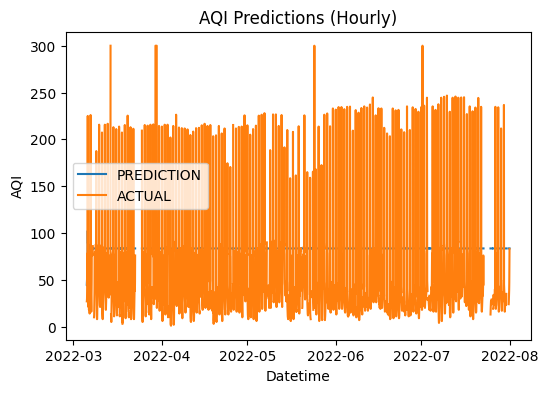

In [13]:
# Group the predictions by hour
predictions_hourly = predictions_df.groupby(pd.Grouper(freq='H')).mean()

# Plot the predictions
plt.figure(figsize=(6,4))
plt.plot(predictions_hourly.index, predictions_hourly['PREDICTION'], label='PREDICTION')
plt.plot(predictions_hourly.index, predictions_hourly['ACTUAL'], label='ACTUAL')
plt.xlabel('Datetime')
plt.ylabel('AQI')
plt.title('AQI Predictions (Hourly)')
plt.legend()
plt.show()


In [14]:
def get_regression_metrics(actual, predicted):
    metrics = dict()
    metrics['MAE'] = mean_absolute_error(actual, predicted)
    metrics['RMSE'] = np.sqrt(mean_squared_error(actual, predicted))
    metrics['R2'] = r2_score(actual, predicted)
    return metrics

# Assuming you have the predictions dataframe with columns 'ACTUAL' and 'PREDICTION'
metrics = get_regression_metrics(predictions_df['ACTUAL'], predictions_df['PREDICTION'])

# Print the metrics
for key, value in metrics.items():
    print(key, ':\t', round(value, 4))


MAE :	 62.4786
RMSE :	 82.4754
R2 :	 -0.0685


## Adjust Model Parameters - Tune

In [15]:
train_labels = train_data['AQI']
test_labels = test_data['AQI']

In [19]:
# Define the parameter grid
p_values = range(0, 30)     # Autoregressive order
d_values = range(0, 30)     # Integration order
q_values = range(0, 30)     # Moving average order

# Initialize variables to store best parameters and performance
best_params = None
best_mse = np.inf

# Perform grid search
for p in p_values:
    for d in d_values:
        for q in q_values:
            try:
                # Initialize the ARIMA model
                model = ARIMA(train_labels, order=(p, d, q))
                # Fit the model
                model_fit = model.fit()

                # Make predictions
                predictions = model_fit.predict(start=len(train_labels), end=len(train_labels)+len(test_data)-1)

                # Calculate mean squared error
                mse = mean_squared_error(test_labels, predictions)

                # Check if current parameters yield better performance
                if mse < best_mse:
                    best_params = (p, d, q)
                    best_mse = mse

            except:
                continue

# Print the best parameters
print("Best Parameters:", best_params)
print("Best MSE:", best_mse)
print("Best RMSE:", np.sqrt(best_mse))

In [ ]:
# define parameters as the best parameters
p = best_params[0]
d = best_params[1]
q = best_params[2]

## Sliding Window with best parameters

In [ ]:
window_size = 24
predictions = []

# Sliding window approach
for i in range(len(train_data) - window_size + 1):
    window_data = train_data[i:i+window_size]
    window_labels = train_labels[i:i+window_size]

    # Fit the ARIMA model on the current window of data
    model = ARIMA(window_labels, order=(p, d, q))
    model_fit = model.fit()

    # Make predictions for the next time step
    next_prediction = model_fit.forecast(steps=1)[0]

    # Store the prediction in the list
    predictions.append(next_prediction)

In [ ]:
predictions_df = pd.DataFrame(predictions, columns=['PREDICTION'], index=test_data.index)
predictions_df['ACTUAL'] = test_labels
print(predictions_df)
metrics = get_regression_metrics(predictions_df['ACTUAL'], predictions_df['PREDICTION'])

for key, value in metrics.items():
    print(key, ':\t', round(value, 4))